## Import Necessary Packages

In [300]:
import pickle
import warnings
import numpy as np
import pandas as pd
import proplot as pplt
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
pplt.rc['figure.dpi'] = 100
warnings.filterwarnings('ignore')

## Load Results

In [301]:
FILEDIR = '/global/cfs/cdirs/m4334/sferrett/monsoon-sr/data/'

with open(f'{FILEDIR}/results/baseline_results.pkl','rb') as file:
    baseresults = pickle.load(file)
    
with open(f'{FILEDIR}/results/v2_results.pkl','rb') as file:
    mlpresults = pickle.load(file)

xtrue = pd.read_parquet(f'{FILEDIR}/processed/Xtest.parquet')['bl']
ytrue = pd.read_parquet(f'{FILEDIR}/processed/ytest.parquet')['pr']

## Functions

In [337]:
def create_log_rain_bins(binspacing=0.08,minleftedge=0.001,maxcenter=1000):
    firstcenter = minleftedge/(1-binspacing/2)
    center      = firstcenter
    bincenters  = []
    binwidths   = []
    while center<=maxcenter:
        width = center*(binspacing)
        bincenters.append(center)
        binwidths.append(width)
        center  = center*(1+binspacing)
    bincenters  = np.array(bincenters)
    binwidths   = np.array(binwidths)
    binedges    = np.zeros(len(bincenters)+1)
    binedges[0] = bincenters[0]-binwidths[0]/2
    for i in range(len(bincenters)):
        binedges[i+1] = bincenters[i]+binwidths[i]/2
    return bincenters,binwidths,binedges

def get_hist(ytrue,ypred):
    nonzeromask  = (ytrue>0)&(ypred>0)
    ytruenonzero = ytrue[nonzeromask]
    yprednonzero = ypred[nonzeromask]
    _,_,binedges = create_log_rain_bins()
    counts,_,_   = np.histogram2d(ytruenonzero,yprednonzero,bins=[binedges,binedges])
    countsmasked = np.ma.masked_where(counts==0,counts)
    return countsmasked,binedges

def get_amount_dist(ydata,drythresh=0.25):
    drydays = ydata<drythresh
    wetdays = ydata[~drydays]
    totalpr = np.sum(wetdays)
    bincenters,binwidths,binedges = create_log_rain_bins()
    counts,_  = np.histogram(wetdays,bins=binedges)
    amtperbin = np.zeros_like(counts)
    for i in range(len(bincenters)):
        inbin = (wetdays>=binedges[i])&(wetdays<binedges[i+1])
        if np.any(inbin):
            amtperbin[i] = np.sum(wetdays[inbin])
    amtcontrib = amtperbin/totalpr
    return {
        'bins':bincenters,
        'widths':binwidths,
        'amtcontrib':amtcontrib,
        'amtperbin':amtperbin}

def hellinger_distance(p,q):
    minlength = min(len(p),len(q))
    p = p[:minlength]
    q = q[:minlength]
    p = p/np.sum(p)
    q = q/np.sum(q)
    return np.sqrt(0.5*np.sum((np.sqrt(p)-np.sqrt(q))**2))

def get_metrics(allmodels,prthresh=0):
    metricsdata = []
    for modelname,results in allmodels.items():
        ytruemodel = results['ytrue']
        ypredmodel = results['ypred']
        r2score = r2_score(ytruemodel,ypredmodel)
        mae  = mean_absolute_error(ytruemodel,ypredmodel)
        mse  = mean_squared_error(ytruemodel,ypredmodel)
        bias = np.mean(ypredmodel-ytruemodel) 
        prthresh   = 0.25
        trueevents = ytruemodel>prthresh
        predevents = ypredmodel>prthresh
        hitrate    = np.sum(trueevents&predevents)/np.sum(trueevents) if np.sum(trueevents)>0 else 0
        far        = np.sum(predevents&~trueevents)/np.sum(predevents) if np.sum(predevents)>0 else 0
        _,_,binedges = create_log_rain_bins()
        histtrue,_ = np.histogram(ytruemodel,bins=binedges,density=True)
        histpred,_ = np.histogram(ypredmodel,bins=binedges,density=True)
        hellinger  = hellinger_distance(histtrue,histpred)
        metricsdata.append({
            'name':modelname,
            'description':results['description'],
            'r2':r2score,
            'mae':mae,
            'mse':mse,
            'bias':bias,
            'hitrate':hitrate,
            'far':far,
            'hellinger':hellinger,
             'nparams':results['nparams']})
    return pd.DataFrame(metricsdata)

def get_model_color(modelname):
    if modelname.startswith('bw_'):
        return 'red6'
    elif 'mae' in modelname:
        return 'yellow6'
    elif 'mse' in modelname:
        return 'blue6'
    else:
        return 'gray' 

def get_complexity_marker(modelname):
    if 'shallow' in modelname or 'bw_0.1' in modelname:
        return 'o'
    elif 'medium' in modelname or 'bw_0.01' in modelname:
        return 's' 
    elif 'deep' in modelname or 'bw_0.001' in modelname:
        return '^'  
    else:
        return 'D'

## Clean Precipitation

In [303]:
allmodels = {}

for modelname,results in baseresults.items():
    ypredvalues = results['ypred']
    ytruevalues = ytrue.values
    validmask = np.isfinite(ypredvalues)&np.isfinite(ytruevalues)
    allmodels[modelname] = {
        'description':results['description'],
        'ypred':ypredvalues[validmask],
        'ytrue':ytruevalues[validmask],
        'nparams':results['nparams']}

for modelname,results in mlpresults.items():
    ypredvalues = results['ypred'].squeeze()
    ytruevalues = ytrue.values
    validmask = np.isfinite(ypredvalues)&np.isfinite(ytruevalues)
    allmodels[modelname] = {
        'description':results['description'],
        'ypred':ypredvalues[validmask],
        'ytrue':ytruevalues[validmask],
        'nparams':results['nparams']}

## Baseline Relationships

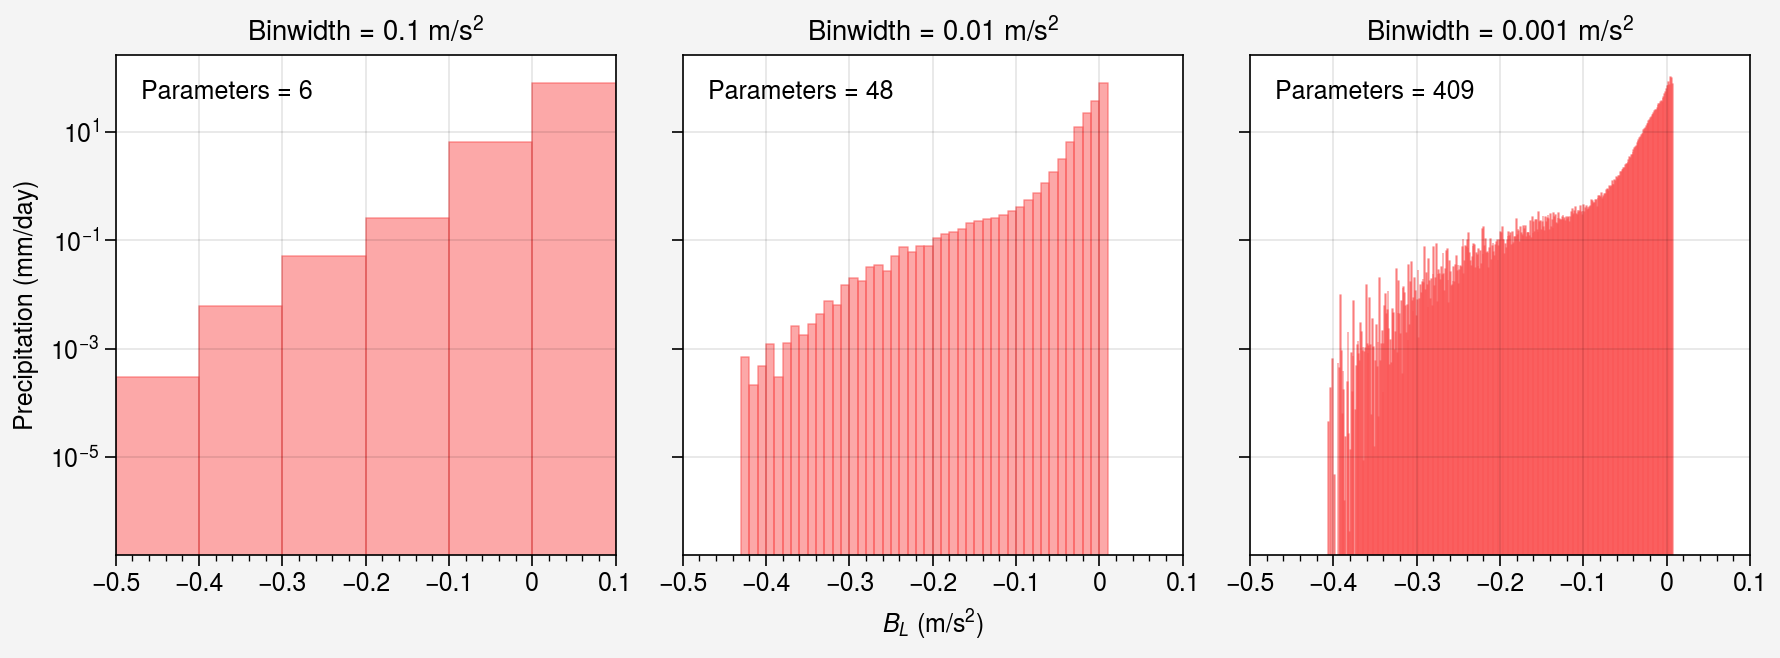

In [304]:
fig,axs = pplt.subplots(nrows=1,ncols=3,share=True)
axs.format(xlabel='$\mathit{B_L}$ (m/s$^2$)',xlim=(-0.5,0.1),xticks=0.1,
           ylabel='Precipitation (mm/day)',yscale='log',yformatter='log')
for i,(modelname,results) in enumerate(baseresults.items()):
    title    = results['description']
    bins     = results['bincenters']
    means    = results['binmeans']
    binwidth = results['binwidth']
    nparams  = results['nparams']
    axs[i].format(title=title)
    for bincenter,meanvalue in zip(bins,means):
        if not np.isnan(meanvalue):
            leftedge  = bincenter-binwidth/2
            rightedge = bincenter+binwidth/2
            axs[i].fill_between([leftedge,rightedge],[0,0],[meanvalue,meanvalue],color='red6',edgecolor='red6',alpha=0.5)
    axs[i].text(0.05,0.95,f'Parameters = {nparams}',transform=axs[i].transAxes,va='top')
pplt.show()

## Model Training and Validation Losses

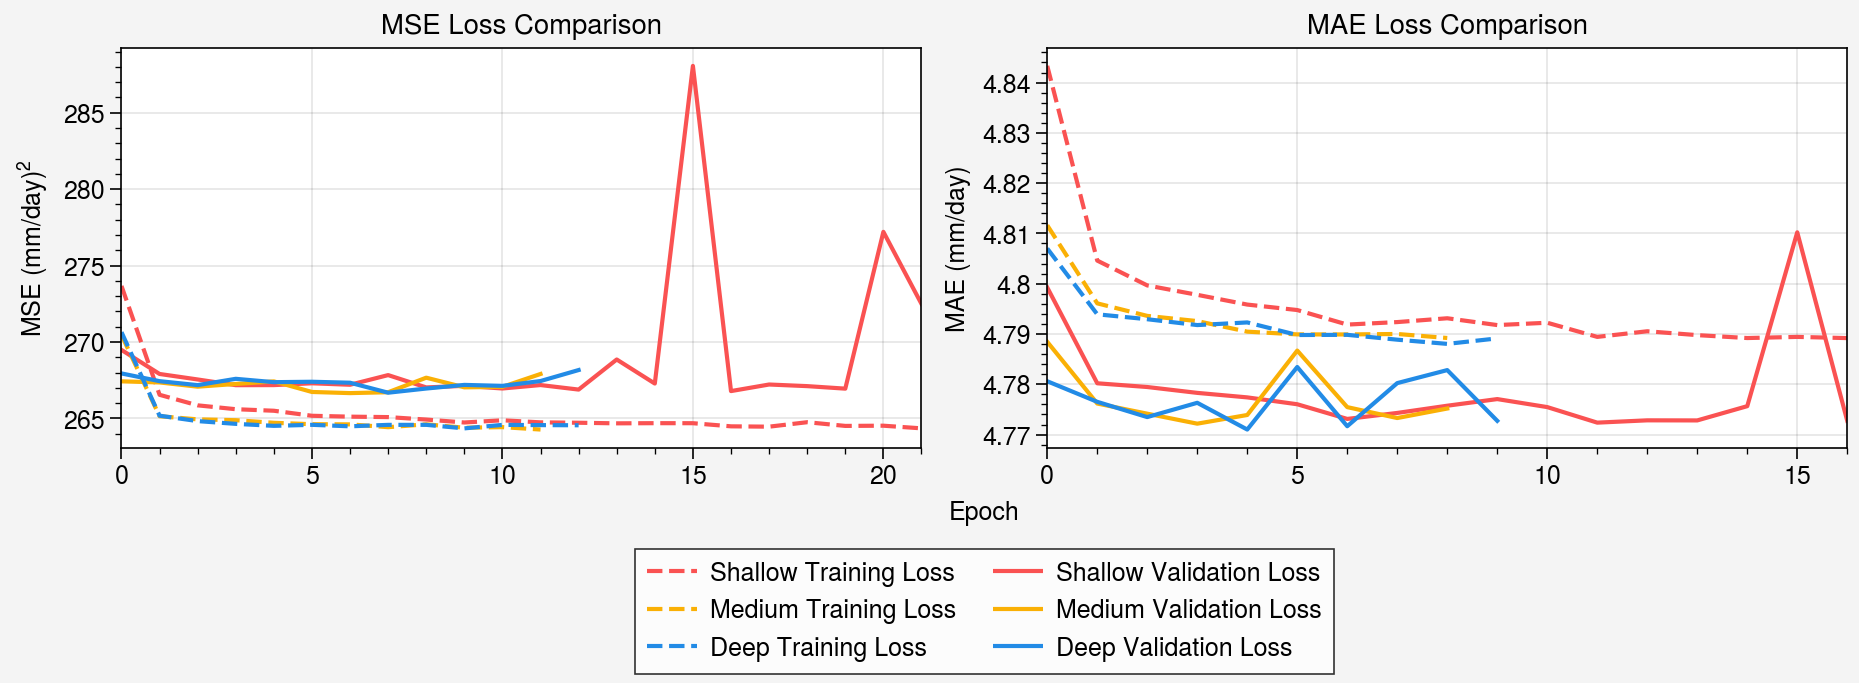

In [305]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,sharex=True,sharey=False)
axs.format(xlabel='Epoch',xticks=5)
axs[0].format(title='MSE Loss Comparison',ylabel='MSE (mm/day)$^2$')
axs[1].format(title='MAE Loss Comparison',ylabel='MAE (mm/day)')

colors = ['red6','yellow6','blue6']
depths = ['shallow','medium','deep']

for i,(ax,loss) in enumerate(zip(axs,['mse','mae'])):
    for j,(depth,color) in enumerate(zip(depths,colors)):
        key = f'{loss}_{depth}'
        if key in mlpresults:
            ax.plot(mlpresults[key]['trainlosses'],color=color,linestyle='--',label=f'{depth.capitalize()} Training Loss' if i==0 else None)
            ax.plot(mlpresults[key]['validlosses'],color=color,linestyle='-',label=f'{depth.capitalize()} Validation Loss' if i==0 else None)
fig.legend(loc='b',ncols=2)
pplt.show()

## Plot Actual vs. Predicted Precipitation

In [312]:
allvalues = []
allvalues.extend(ytrue.values)
for modelname,results in baseresults.items():
    allvalues.extend(results['ypred'])
for modelname,results in mlpresults.items():
    allvalues.extend(results['ypred'].squeeze())

allvalues = np.array(np.array(allvalues))
allvalues = allvalues[np.isfinite(allvalues)]
    
globalmin = np.min(allvalues) 
globalmax = np.max(allvalues)
print(f'Predicted precipitation ranges from {globalmin} to {globalmax:.2f} mm/day')

Predicted precipitation ranges from 0.0 to 876.11 mm/day


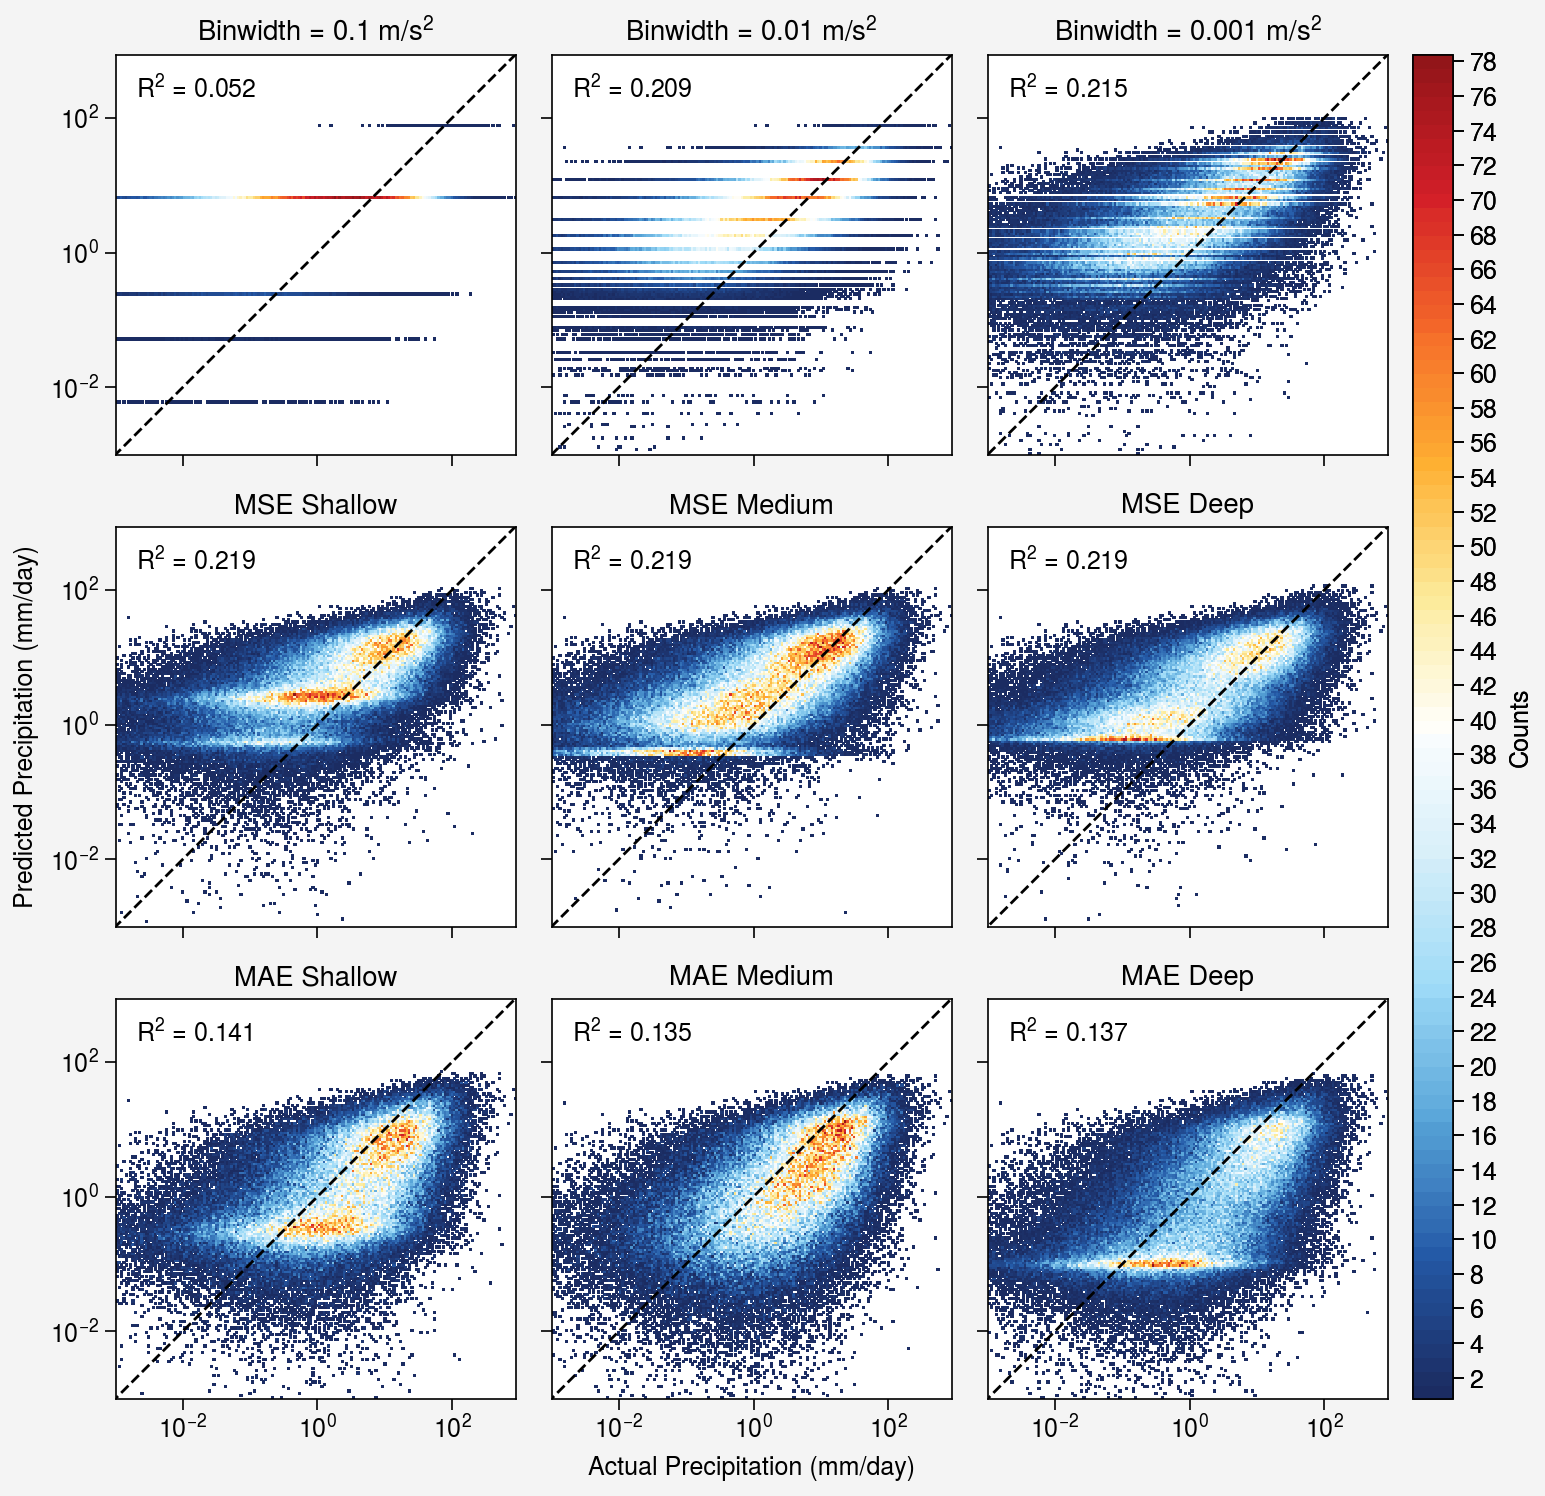

In [313]:
ticks   = [1e-4,1e-2,1e0,1e2]
ncols   = 3
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,share=True)

for i,(modelname,results) in enumerate(allmodels.items()):
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score    = r2_score(ytruemodel,ypredmodel)
    hist,binedges = get_hist(ytruemodel,ypredmodel)
    im = axs[row,col].pcolormesh(binedges,binedges,hist.T,cmap='ColdHot',levels=100)
    axs[row,col].plot([globalmin,globalmax],[globalmin,globalmax],'k--',linewidth=1)
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])

for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')
    
axs.format(xlabel='Actual Precipitation (mm/day)',xscale='log',xformatter='log',
           xlim=[globalmin,globalmax],xticks=ticks,xminorticks='none',
           ylabel='Predicted Precipitation (mm/day)',yscale='log',yformatter='log',
           ylim=[globalmin,globalmax],yticks=ticks,yminorticks='none')

fig.colorbar(im,loc='r',label='Counts',ticks=2)
pplt.show()

## Actual vs. Predicted Amount Distributions

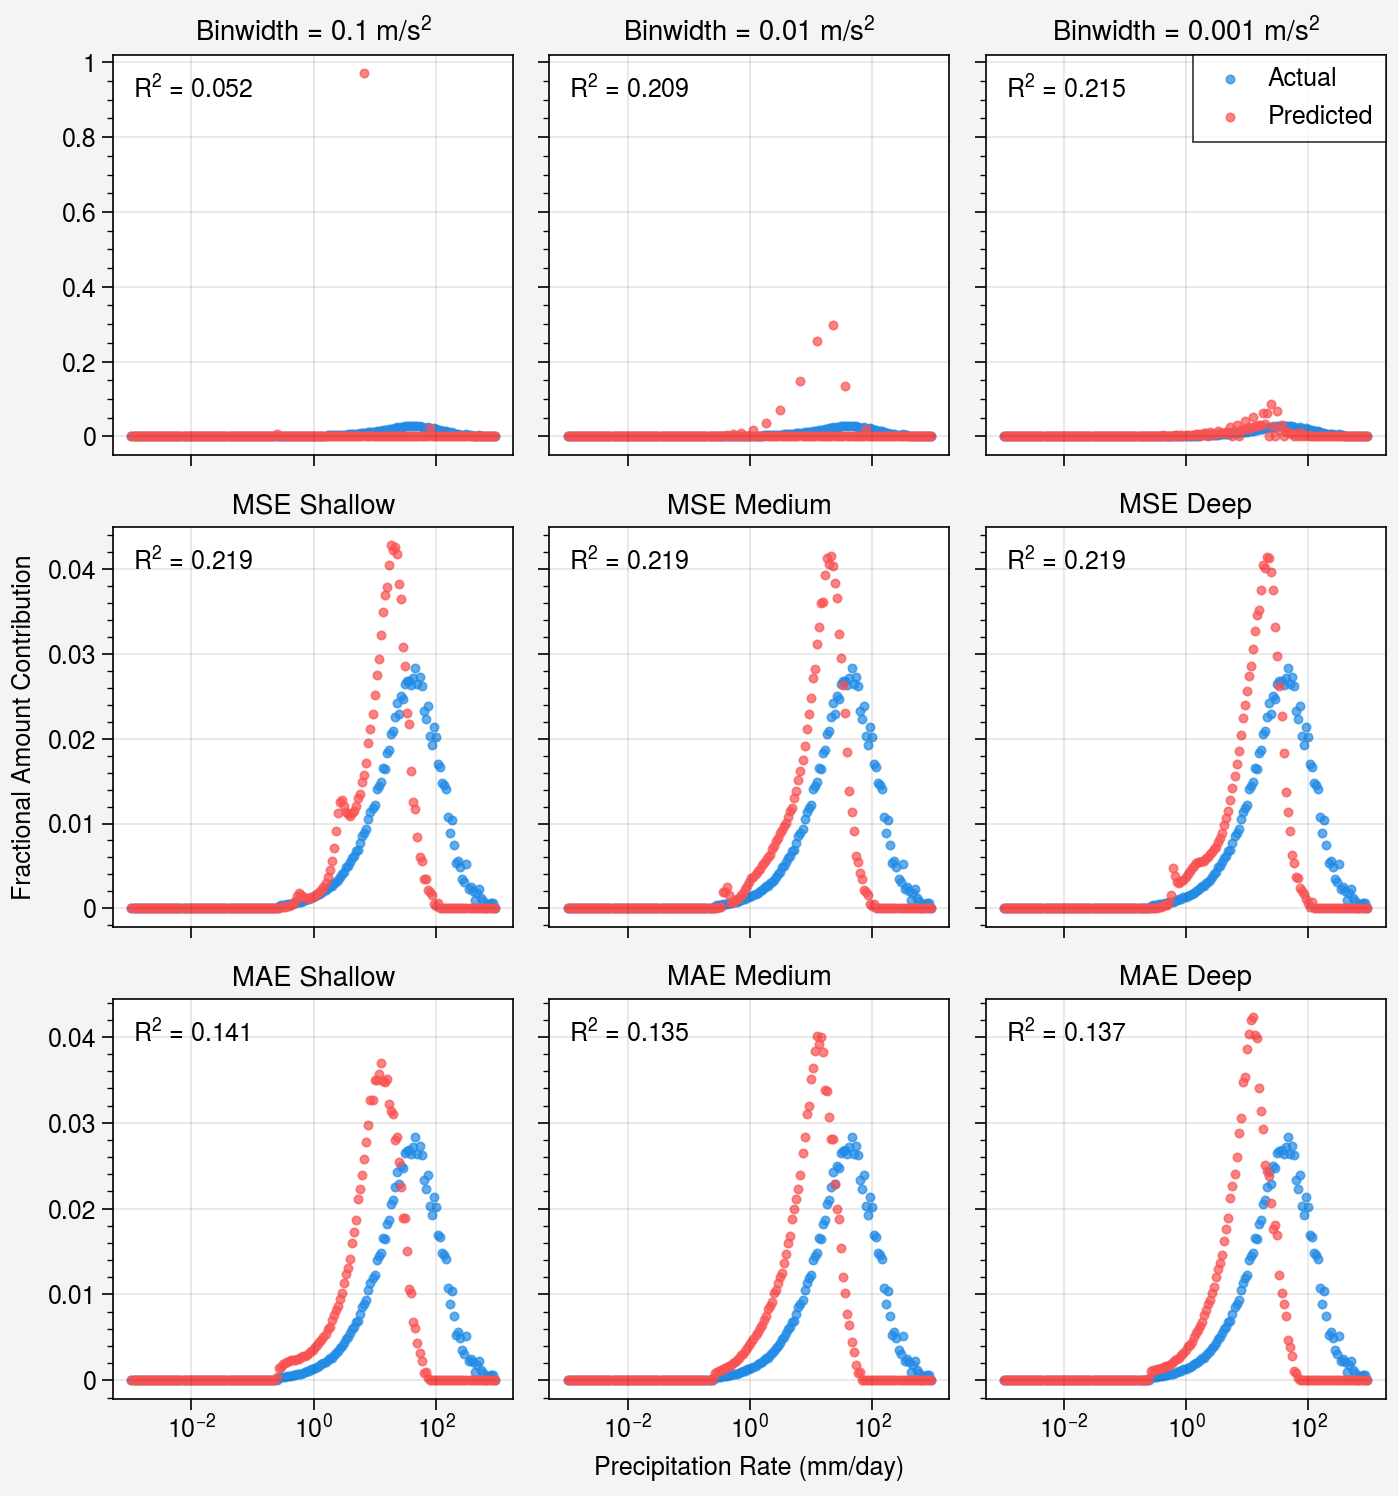

In [314]:
ticks   = [1e-4,1e-2,1e0,1e2]
ncols   = 3
nrows   = (len(allmodels)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=2,spany=True)

for i,(modelname,results) in enumerate(allmodels.items()):
    row = i//ncols
    col = i%ncols
    ytruemodel = results['ytrue']
    ypredmodel = results['ypred']
    r2score    = r2_score(ytruemodel,ypredmodel)
    disttrue   = get_amount_dist(ytruemodel)
    distpred   = get_amount_dist(ypredmodel)
    axs[row,col].scatter(disttrue['bins'],disttrue['amtcontrib'],color='blue6',marker='.',alpha=0.7,label='Actual')
    axs[row,col].scatter(distpred['bins'],distpred['amtcontrib'],color='red6',marker='.',alpha=0.7,label='Predicted')
    axs[row,col].text(0.05,0.95,f'R$^2$ = {r2score:.3f}',transform=axs[row,col].transAxes,va='top',ha='left')
    axs[row,col].format(title=results['description'])
axs[2].legend(loc='ur',ncols=1)

for i in range(len(allmodels),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

axs.format(xlabel='Precipitation Rate (mm/day)',xscale='log',xformatter='log',
           ylabel='Fractional Amount Contribution')

pplt.show()

## Plot Metrics

In [331]:
metricsdf = get_metrics(allmodels)
metricsdf

,name,description,r2,mae,mse,bias,hitrate,far,hellinger,nparams
0,bw_0.1,Binwidth = 0.1 m/s$^2$,0.051987,7.259213,274.196551,0.187957,0.995649,0.501779,0.920428,6
1,bw_0.01,Binwidth = 0.01 m/s$^2$,0.209199,5.595282,227.468553,0.158549,0.981690,0.475383,0.685547,48
2,bw_0.001,Binwidth = 0.001 m/s$^2$,0.215191,5.539324,223.882385,0.154973,0.982440,0.476905,0.383185,409
3,mse_shallow,MSE Shallow,0.219275,5.430262,225.811279,-0.100544,0.924748,0.398879,0.568427,8961
4,mse_medium,MSE Medium,0.218981,5.509985,225.896454,0.066616,0.975935,0.465224,0.688757,42625
5,mse_deep,MSE Deep,0.219401,5.493094,225.774872,0.033825,0.970255,0.456041,0.700769,46913
6,mae_shallow,MAE Shallow,0.141309,4.625797,248.361679,-3.262776,0.716115,0.266188,0.450021,8961
7,mae_medium,MAE Medium,0.135370,4.629720,250.079575,-3.337235,0.671133,0.246970,0.336246,42625
8,mae_deep,MAE Deep,0.136774,4.625047,249.673370,-3.306415,0.665970,0.245012,0.446578,46913


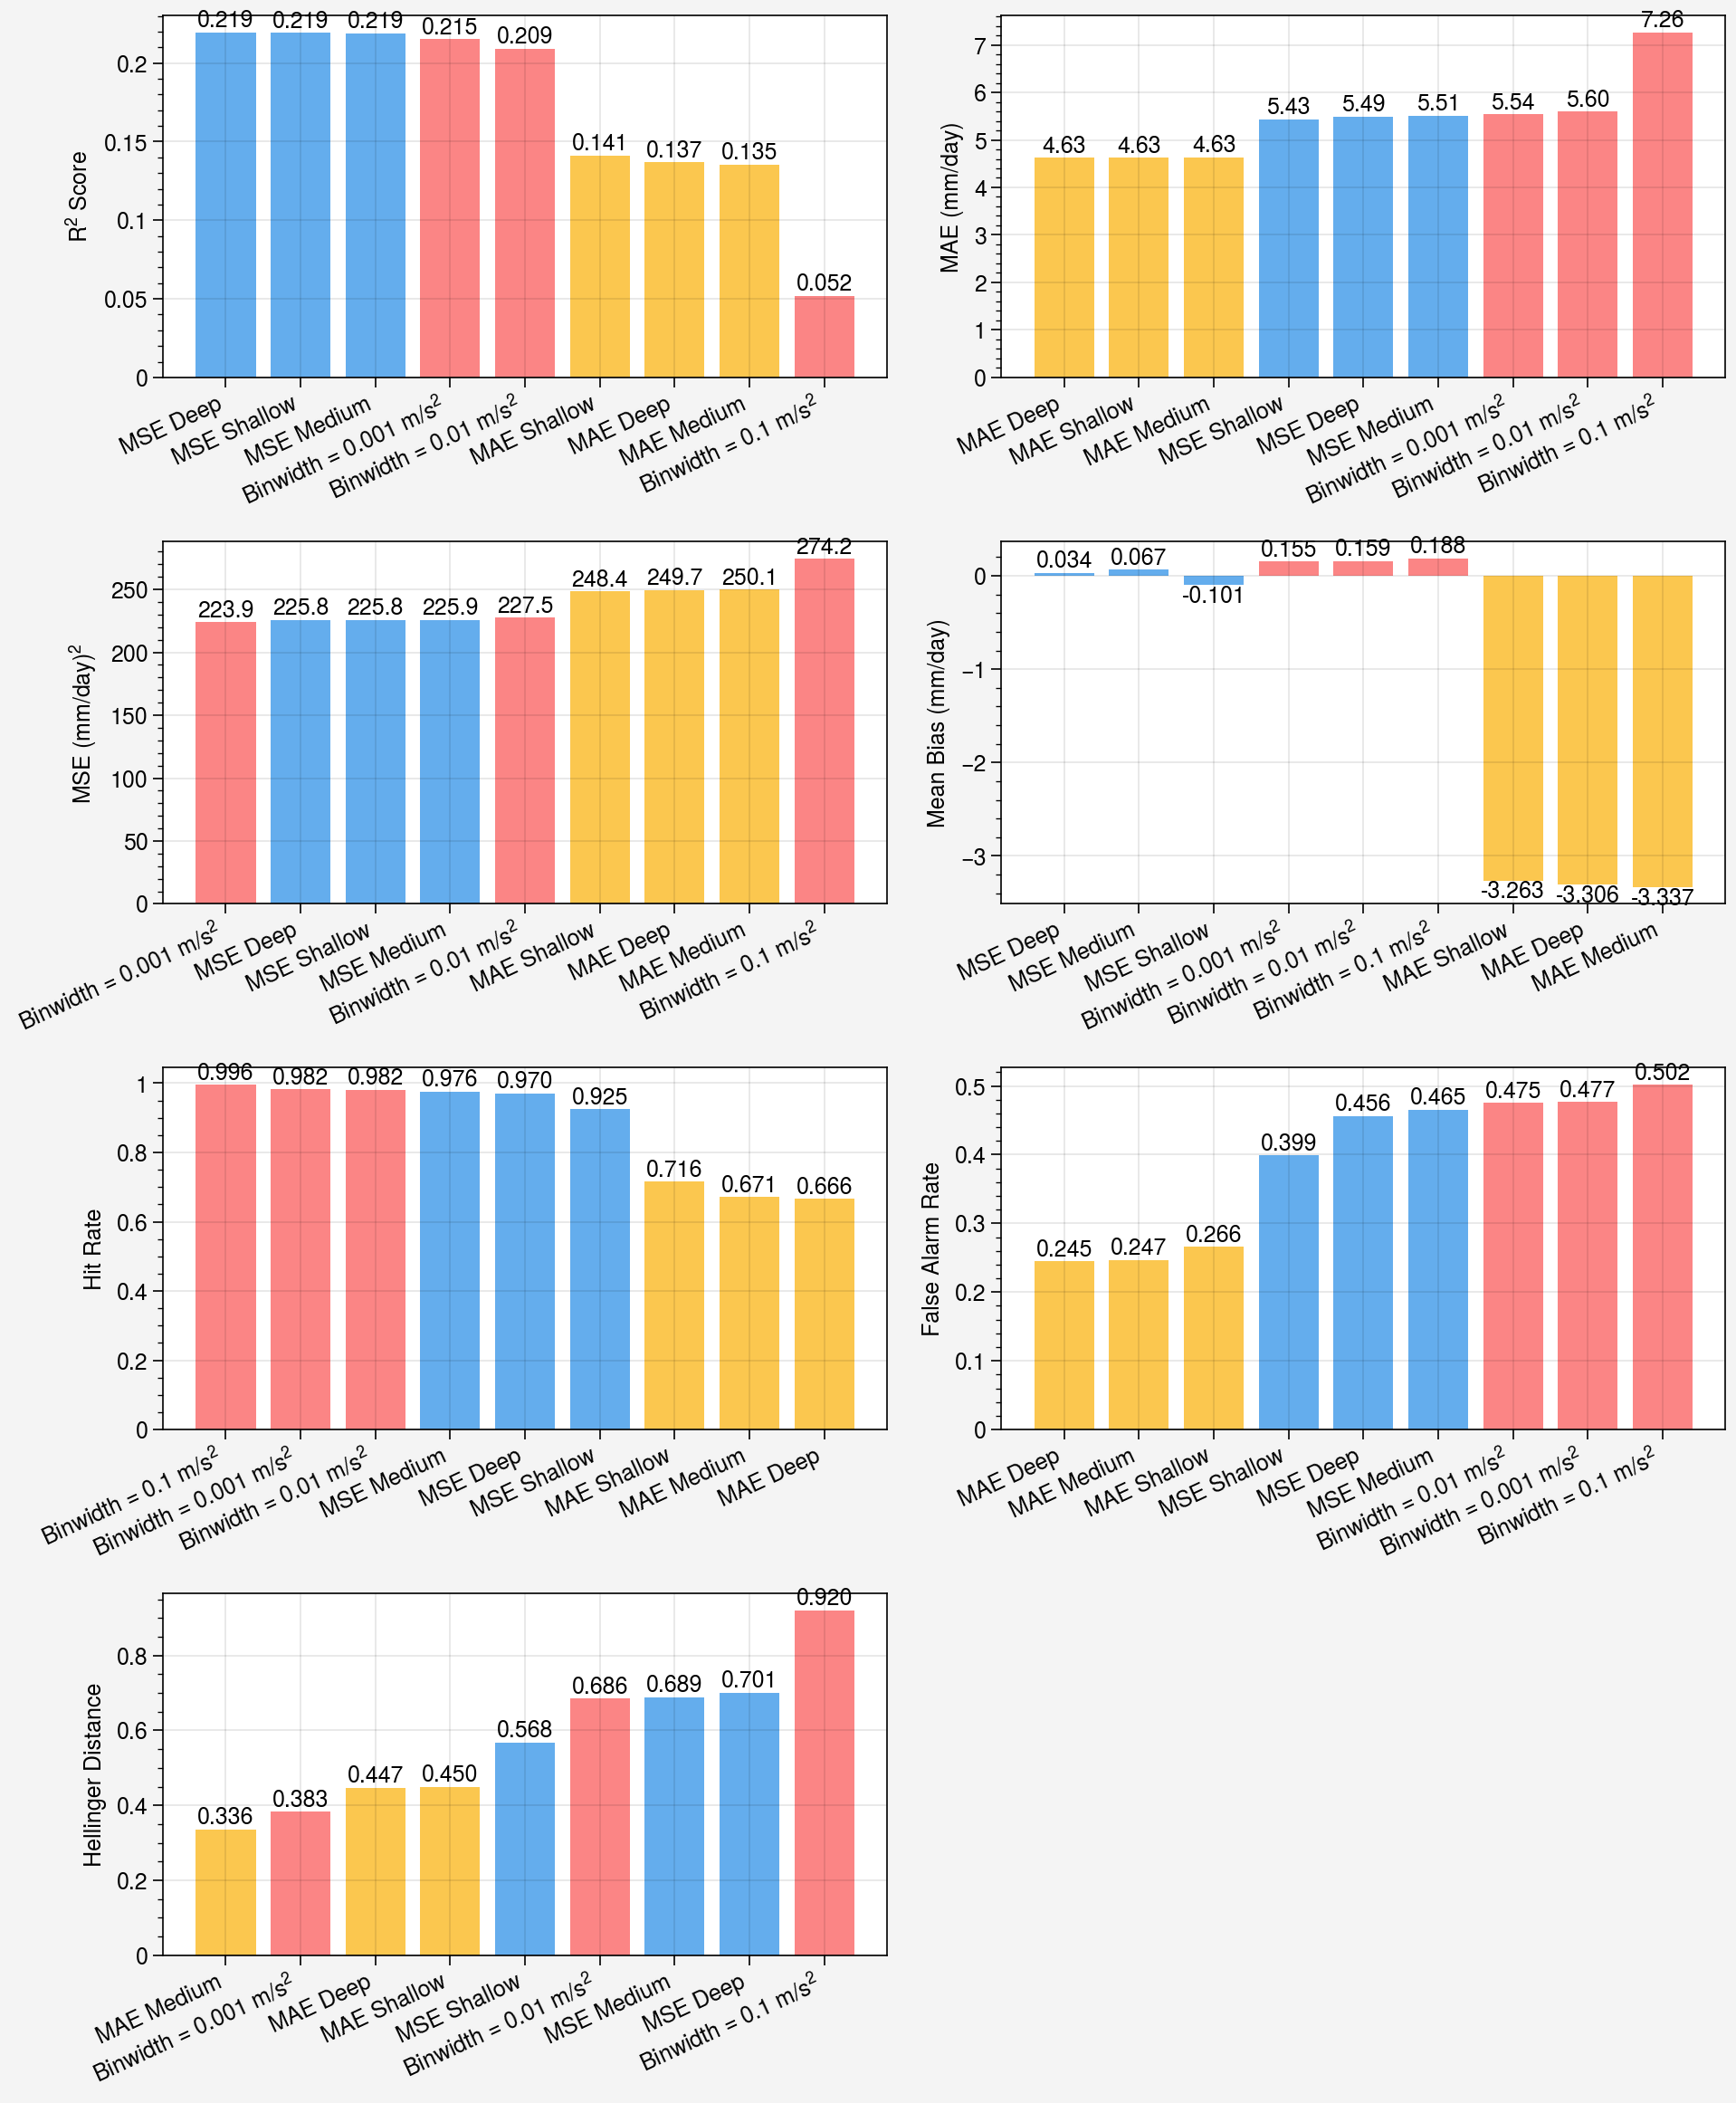

In [334]:
metricsconfig = {
    'r2': {'title':'R$^2$ Score','higher_better':True,'format':'.3f'},
    'mae':{'title':'MAE (mm/day)','higher_better':False,'format':'.2f'},
    'mse':{'title':'MSE (mm/day)$^2$','higher_better':False,'format':'.1f'},
    'bias':{'title':'Mean Bias (mm/day)','higher_better':None,'format':'.3f'},
    'hitrate':{'title':'Hit Rate','higher_better':True,'format':'.3f'},
    'far':{'title':'False Alarm Rate','higher_better':False,'format':'.3f'},
    'hellinger':{'title':'Hellinger Distance','higher_better': False,'format':'.3f'}}

ncols   = 2
nrows   = (len(metricsconfig)+ncols-1)//ncols
fig,axs = pplt.subplots(nrows=nrows,ncols=ncols,refwidth=4,refheight=2,share=False)

for i,(metric,config) in enumerate(metricsconfig.items()):
    row = i//ncols
    col = i%ncols
    if config['higher_better'] is True:
        sorteddf = metricsdf.sort_values(metric, ascending=False)
    elif config['higher_better'] is False:
        sorteddf = metricsdf.sort_values(metric, ascending=True)
    else:
        sorteddf = metricsdf.sort_values(metric, key=abs, ascending=True)
    
    colors = [get_model_color(name) for name in sorteddf['name']]
    bars = axs[row,col].bar(range(len(sorteddf)),sorteddf[metric],color=colors,alpha=0.7)
    axs[row,col].format(ylabel=config['title'],xminorticks='none')
    
    for j,(bar,value) in enumerate(zip(bars,sorteddf[metric])):
        height = bar.get_height()
        va   = 'bottom' if height>=0 else 'top'
        ypos = height if height>=0 else height
        axs[row,col].text(bar.get_x()+bar.get_width()/2.,ypos,f'{value:{config["format"]}}',ha='center',va=va)
    axs[row,col].set_xticks(range(len(sorteddf)))
    axs[row,col].set_xticklabels([d for d in sorteddf['description']],ha='right',rotation=25)

for i in range(len(metricsconfig),nrows*ncols):
    row = i//ncols
    col = i%ncols
    axs[row,col].axis('off')

pplt.show()

## Plot Pareto Front

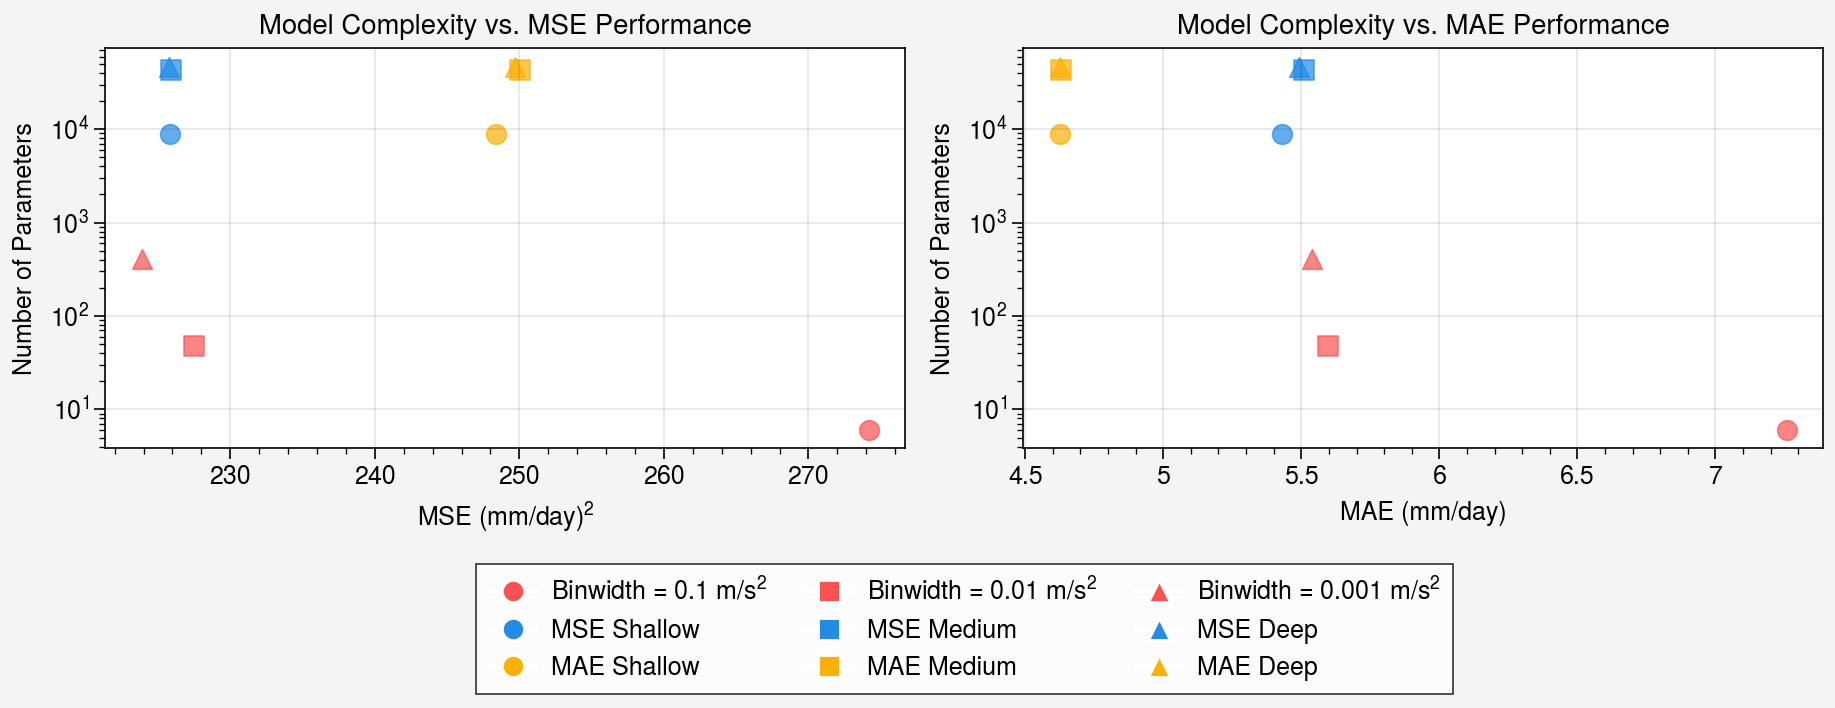

In [342]:
fig,axs = pplt.subplots(nrows=1,ncols=2,refwidth=4,refheight=2,share=False)

truevar = metricsdf['mse'].max()/(1-metricsdf['r2'].max()) if metricsdf['r2'].max()<0.99 else metricsdf['mse'].max()*2
r209    = truevar*(1-0.9)  
r2095   = truevar*(1-0.95) 

axs[0].format(title='Model Complexity vs. MSE Performance',
              xlabel='MSE (mm/day)$^2$',
              # xscale='log',xformatter='log',xlim=(1e2,1e3),
              ylabel='Number of Parameters',yscale='log',yformatter='log')
axs[1].format(title='Model Complexity vs. MAE Performance',
              xlabel='MAE (mm/day)',
              # xscale='log',xformatter='log',xlim=(1e0,1e1),
              ylabel='Number of Parameters',yscale='log',yformatter='log')

colors  = [get_model_color(name) for name in metricsdf['name']]
markers = [get_complexity_marker(name) for name in metricsdf['name']]

from matplotlib.lines import Line2D
elements = []
for i,row in metricsdf.iterrows():
    axs[0].scatter(row['mse'],row['nparams'],color=colors[i], marker=markers[i],markersize=50,alpha=0.7)
    axs[1].scatter(row['mae'],row['nparams'],color=colors[i],marker=markers[i],markersize=50,alpha=0.7)
    elements.append(Line2D([0],[0],marker=markers[i],color='w',markerfacecolor=colors[i],markersize=8,label=row['description']))
fig.legend(handles=elements,loc='b',ncols=3)

pplt.show()